In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import glob
import xml.etree.ElementTree as etree
%matplotlib inline

import os
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import time

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
all_images = glob.glob('../data/original_images/*')
all_images = [name.split('/')[-1] for name in all_images]

In [4]:
class HandSignDataset(Dataset):
    
    def __init__(self, all_images, transform=None):
        self.all_images = all_images
        self.transform = transform
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        image = io.imread('../data/original_images/' + self.all_images[idx])
        
        skin_mask = io.imread('../data/skin_masks/' + \
                              self.all_images[idx].split('.')[0] + '.bmp')
        
        feature_points_file = etree.parse('../data/feature_points/' + \
                                   self.all_images[idx].split('.')[0] + '.xml')
        
        root = feature_points_file.getroot()

        xs, ys = [], []

        for child in root:
            for element in child:
                if element.attrib.get('type') == 'Fingertip':
                    xs.append(int(element.attrib.get('x')))
                    ys.append(int(element.attrib.get('y')))

        xs, ys = np.array(xs).reshape(1, -1), np.array(ys).reshape(1, -1)
        points = np.concatenate([xs, ys], axis=0)            
            
        sample = {'image': image, 'skin_mask': skin_mask, 
                  'feature_points' : points}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
def show_hand(image, skin_mask, feature_points):
    fig = plt.figure()

    ax1 = plt.subplot(1, 2, 1)
    plt.tight_layout()
    ax1.set_title('Original')
    ax1.axis('off')

    plt.imshow(image)
    plt.scatter(feature_points[0], feature_points[1], s = 40, marker='.', c='r')

    ax2 = plt.subplot(1, 2, 2)
    plt.tight_layout()
    ax2.set_title('Skin Mask')
    ax2.axis('off')

    plt.imshow(skin_mask)
    plt.scatter(feature_points[0], feature_points[1], s = 40, marker='.', c='r')
    
    plt.show()

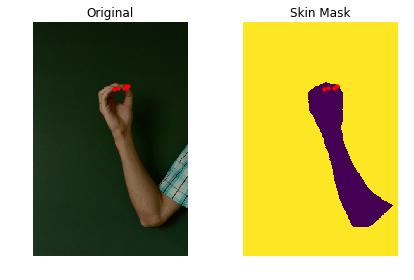

In [6]:
handData = HandSignDataset(all_images)

show_hand(**handData[2])

In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, skin_mask, feature_points = sample['image'], sample['skin_mask'], \
                                           sample['feature_points']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size, self.output_size

        image = transform.resize(image, (new_h, new_w))
        skin_mask = transform.resize(skin_mask, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        feature_points = feature_points * [[new_w / w], [new_h / h]]
    
        return {'image': image, 'skin_mask': skin_mask, 
                'feature_points' : feature_points}

In [8]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, skin_mask, feature_points = sample['image'], sample['skin_mask'], \
                                           sample['feature_points']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, min(h - new_h, min(feature_points[1])))
        left = np.random.randint(max(0, max(feature_points[0]) - new_w), w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        skin_mask = skin_mask[top : top + new_h,
                              left: left + new_w]
        
        feature_points = feature_points - [[left], [top]]

        return {'image': image, 'skin_mask': skin_mask, 
                'feature_points' : feature_points}


In [9]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, skin_mask, feature_points = sample['image'], sample['skin_mask'], \
                                           sample['feature_points']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        # Pad feature_points with -1
        if feature_points.shape[1] < 5:
            pad = np.zeros([2, 5 - feature_points.shape[1]])
            pad.fill(0)
            feature_points = np.concatenate([feature_points, pad], axis=1)
        
        return {'image' : torch.from_numpy(image).type(torch.FloatTensor),
                'skin_mask' : torch.from_numpy(skin_mask).type(torch.LongTensor), 
                'feature_points' : torch.from_numpy(feature_points).type(torch.FloatTensor)}

In [10]:
class Normalize(object):
    """ Normalize image / skin_mask to feed to ResNet """
    def __call__(self, sample):
        image, skin_mask, feature_points = sample['image'], sample['skin_mask'], \
                                               sample['feature_points']

        normalize_op = transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                           std = [ 0.229, 0.224, 0.225 ])

        image = normalize_op(image)

        return {'image': image, 'skin_mask': skin_mask, 
                'feature_points' : feature_points}

In [17]:
data_transforms = {
    'train' : transforms.Compose([
                                  Rescale(256),
                                  #RandomCrop(224),
                                  ToTensor(),
                                  Normalize()
                              ]),
    'val' : transforms.Compose([
                                  Rescale(256),
                                  #RandomCrop(224),
                                  ToTensor(),
                                  Normalize()
                              ]),
}

transformed_dataset = {x : HandSignDataset(all_images, transform = data_transforms[x])
                                      for x in ['train', 'val']}

data_loaders = {x : DataLoader(transformed_dataset[x], batch_size=64, shuffle=True, num_workers=4)
                                        for x in ['train', 'val']}

data_sizes = {x : len(transformed_dataset[x]) for x in ['train', 'val']}

#for i in range(2):
#    batched_sample = next(iter(data_loaders['train']))
#    print(batched_sample['skin_mask'].size())


In [18]:
sample = next(iter(data_loaders['train']))

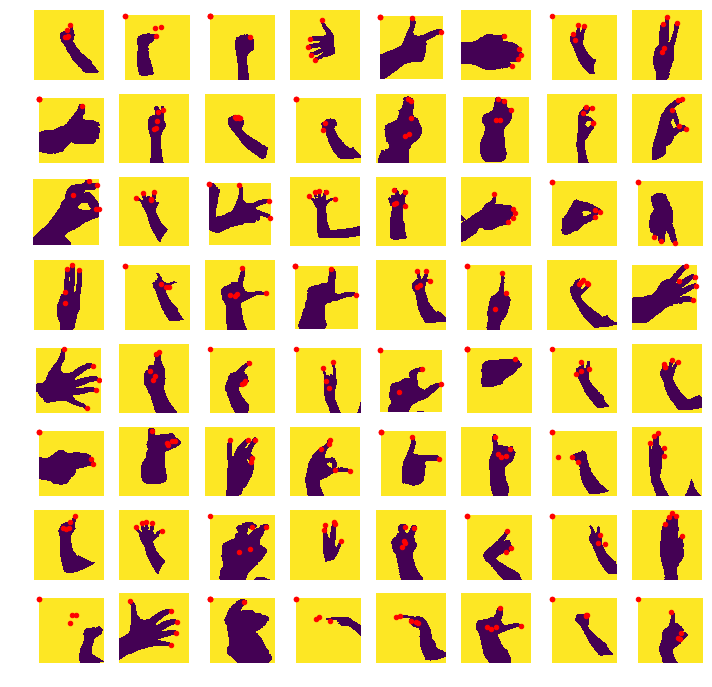

In [19]:
gs1 = gridspec.GridSpec(8, 8)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))

for i in range(64):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    
    plt.subplot(8, 8, i+1)
    plt.imshow(sample['skin_mask'][i].numpy())
    plt.scatter(sample['feature_points'][i][0].numpy(), sample['feature_points'][i][1].numpy(), c='r', s=20)
    plt.axis('off')

plt.show()

In [24]:
def train_model(model, criterion, optimizer, lr_scheduler, data_loaders, data_sizes, num_epochs = 25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model = model
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode
            
            running_loss = 0.0

            # Iterate over data
            for data in data_loaders[phase]:
                # get the inputs
                image, skin_mask, feature_points = data['image'], data['skin_mask'], \
                                                   data['feature_points'] 
                
    
                # wrap them in Variable
                if use_gpu:
                    image, skin_mask, feature_points = Variable(image.cuda()), \
                                                       Variable(skin_mask.cuda()), \
                                                       Variable(feature_points.cuda())
                    model = model.cuda()
                else:
                    image, skin_mask, feature_points = Variable(image), \
                                                       Variable(skin_mask), \
                                                       Variable(feature_points)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                output = model(image)
                loss = criterion(output, skin_mask)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
    
            epoch_loss = running_loss / data_sizes[phase]

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_model = copy.deepcopy(model)
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return best_model

In [25]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [13]:
from net import UNet
from criterion import CrossEntropyLoss2d
from torch.optim import SGD

In [14]:
weight = torch.ones(2)
weight[0] = 0

if torch.cuda.is_available():
    weight = weight.cuda()

loss = CrossEntropyLoss2d(weight)
net = UNet(num_classes=2)

optimizer = SGD(net.parameters(), 1e-3, .9)

In [33]:
import gc
gc.collect()

0